## Project overview
The main objective of the following project is to create a generator that allow users across different departments (even without prgramming knowledge) to finish the process of extracting essential data from multiple tables in database, data processing and data analysis within seconds and only with a few clicks.

##### 1. Starting page of .exe file

In [ ]:
##### 1. Starting page of .exe file
now = dt.datetime.now().hour
if 5 < now < 12:
    print('============================================\nGood morning, thank you for using this client usage report generator\n============================================\n')
elif 12 <= now < 18:
    print('============================================\nGood afternoon, thank you for using this client usage report generator\n============================================\n')
else:
    print('============================================\nGood evening, thank you for using this client usage report generator\n============================================\n')

print('''【Introduction】
The main aim of this toolkit is to let every users extract product usage data for each of our client efficiently and timely.

Formerly, you need to log into database to retrive data from different table respectively and copy those output to separate Excel sheets, finally creating pivot tables in Excel to receive the desired data.

With this toolkit, you can do all these only with a few clicks!

【Please note】

1.Make sure you are connected to company's WIFI when using.
2.Make sure you have file "log_name.xlsx" in your folder.

============================================\n''')

##### 2. Check if an excel file imported for later data processing use exists in relative path 

In [ ]:
print('>>> Checking if file "log_name.xlsx exists"...', end='')
sys.stdout.flush()
if glob.glob('data/log_name.xlsx'):
    print('File exists！')
else:
    print('File does\'nt exist, please make sure you have it in the folder')
    sys.exit(0)

##### 3. Enter the variable that you want the users to put in, e.g., your clent's account name and date

In [ ]:
acc_txt = "\'" + str(input('>>> Please enter client\'s service account and press enter to continue')) + "\'"

while True:
    start_time = str(input('>>> Please enter the start date in YYYY-MM-DD format (ex: 2020-09-21) and press enter to continue'))
    if len(start_time) == 10:
        break
    else:
        print('It seems that wrong date format has been entered, please try again')

while True:
    end_time = str(input('>>> Please enter the end date in YYYY-MM-DD format (ex: 2020-09-21) and press enter to continue'))
    if len(end_time) == 10:
        break
    else:
        print('It seems that wrong date format has been entered, please try again')

##### 4. Start extracting data from database

In [ ]:
print('\n>>> Now retrieving usage report >>> Clien\'s service account：%s, Time: from %s to %s。\n' %(acc_txt, start_time, end_time))

print('>>> Now reading "log_name" file...', end='')
sys.stdout.flush()
log_name = pd.read_excel('data/log_name.xlsx')  # English and Chinese function name lookup table (log_name)
print('Done!')

# SQL queries
print('>>> Connecting to database ...', end='')
sys.stdout.flush()
conn = pyodbc.connect('Driver={SQL Server};Server=10.20.20.1;Database=opv_general;UID=asap;PWD=asap1234')  # Connect to the database
print('Done!')

# Search history
sql_1 = """SELECT *
            FROM TABLE_1
            WHERE column_A in (%s)  --Enter service accont 
            AND column_B!='XXX'  -- Exclude specific column with specific value. For example, filter out internal value.
            AND time >= '%s' --Start date
            AND time < '%s' --End date
            ORDER by create_time ASC;  --Sort from oldest to newest """ % (acc_txt, start_time, end_time)

# Login history
sql_2 = """SELECT *
            FROM TABLE_2
            WHERE column_A in (%s)  --Enter service accont
            AND created_time >= '%s'
            AND created_time < '%s'
            AND status ='success'
            ORDER by create_time ASC;  --Sort from oldest to newest;""" % (acc_txt, start_time, end_time)

# Topic edit history
sql_3 = """SELECT a.column_A ,b.* FROM TABLE_3 a inner join TABLE_4 b ON a.column = b.column
           WHERE a.column_A in (%s)
           AND b.update_time >= '%s'
           AND b.update_time < '%s'""" % (acc_txt, start_time, end_time)

# Executing SQL queries
print('>>> Extracting search history...', end='')
sys.stdout.flush()
search = pd.read_sql(sql_1, conn)
search.reset_index(drop=True, inplace=True)
print('Done!')

print('>>> Extracting login history...', end='')
sys.stdout.flush()
login = pd.read_sql(sql_2, conn)
print('Done!')

print('>>> Extracting Topic edit history...', end='')
sys.stdout.flush()
changetopic = pd.read_sql(sql_3, conn)
print('Done!')


##### 5. Data processing

In [ ]:
print('>>> Processing client usage report ...', end='')
sys.stdout.flush()
search = search.merge(log_name, how='inner', left_on='module_name', right_on='English_finction_name')   #Replace english function name with Chinese function name
search.drop('English_finction_name', axis=1, inplace=True)
search['create_time'] = pd.to_datetime(search['create_time'])
print('Done!')

print('>>> Processing login history ...', end='')
sys.stdout.flush()
login.columns = ['id', 'service_account', 'user_account', 'IP', 'status', 'login_time'] #Reorder and select needed columns
print('Done!')
print('Done!')

##### 6. Analysis

In [ ]:
# Define a pivot table function
print('>>> Analysis in progress ...', end='')
sys.stdout.flush()
search['Year_month'] = search['create_time'].dt.strftime('%Y-%m')#Add column for analysis purpose
def top_n(name):
    output = search.groupby([name, 'Year_month'])[name].count().unstack()
    output.reset_index(inplace=True)
    output.fillna(0, inplace=True)
    output['Total_usage'] = output.sum(axis=1, numeric_only=True)
    output = output.sort_values(by=['Total_usage'], ascending=False)
    return output

# Most searched topic ranking analysis
hot_topic = top_n('topic_name')

# Most frequent user ranking analysis
hot_user = top_n('user_account')

# Most used function ranking analysis
hot_func = top_n('function_name_Chinese')
print('Done!')

##### 7. Save the output into excel file

In [ ]:
##### 7. Save the output into excel file
print('>>> Saving ...')
sys.stdout.flush()
with pd.ExcelWriter('output/client_usage_report_%s_%s-%s.xlsx' %(acc_txt, start_time.replace('-', ''), end_time.replace('-', ''))) as writer:
    search.to_excel(writer, sheet_name='01 Search history', index=False)
    login.to_excel(writer, sheet_name='02 Login history', index=False)
    changetopic.to_excel(writer, sheet_name='03 Topic edit history', index=False)
    hot_topic.to_excel(writer, sheet_name='A. Topic ranking analysis', index=False)
    hot_user.to_excel(writer, sheet_name='B. Users ranking analysis', index=False)
    hot_func.to_excel(writer, sheet_name='C. Function ranking analysis', index=False)
print('%s %s-%s usage report has been saved。' %(acc_txt, start_time.replace('-', ''), end_time.replace('-', '')))

#### Then we're good to go!

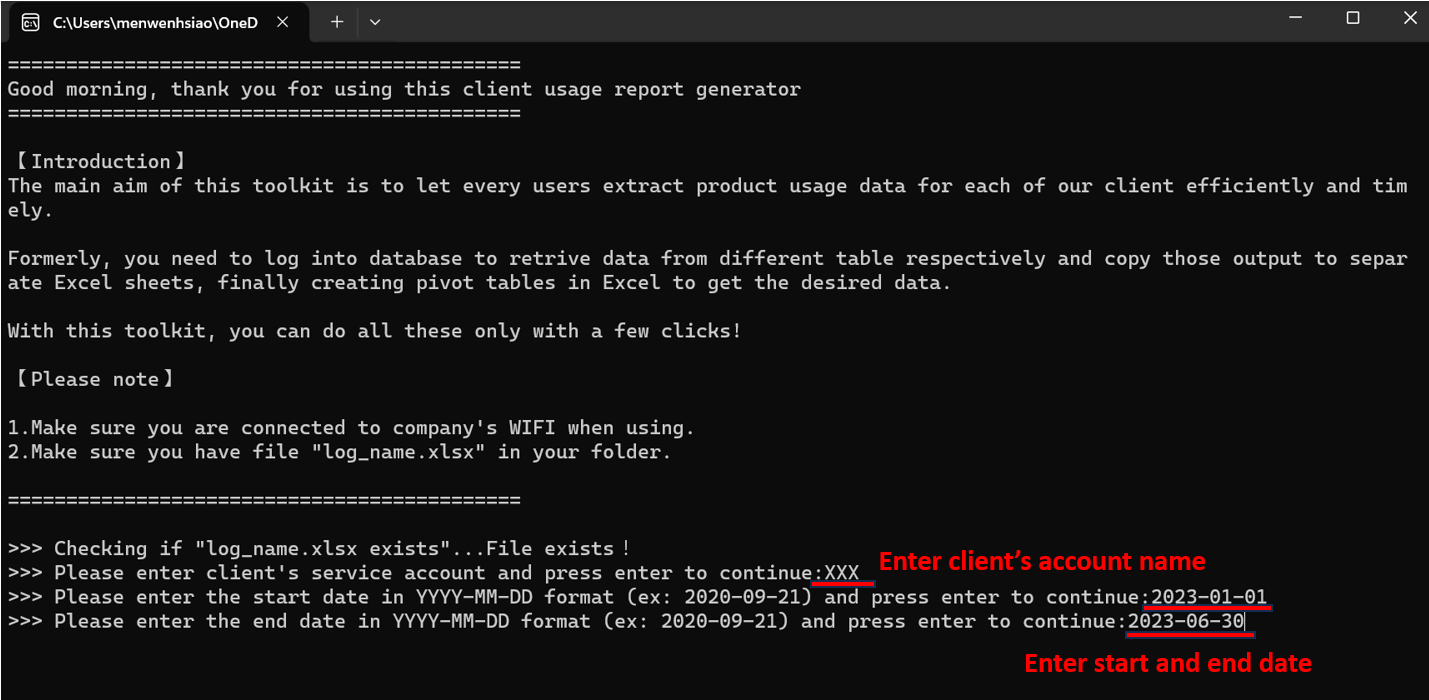